# The usual imports.

In [1]:
from keras import models, layers
import numpy as np
import glob2
import matplotlib.pyplot as plt
import json
import pprint
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import preprocessing
import progressbar
import random
import datetime

/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
# Here you can use a user defined path.
if os.path.exists("datasetpath.txt"):
    dataset_path = open("datasetpath.txt", "r").read()
else:
    dataset_path = "../data"

print("Dataset path:", dataset_path)

Dataset path: ../data



# Get a grip on the data.

In [3]:
# Getting the paths for images.
glob_search_path = os.path.join(dataset_path, "**/*.jpg")
jpg_paths = glob2.glob(glob_search_path)

# Getting the paths for point clouds.
glob_search_path = os.path.join(dataset_path, "**/*.pcd")
pcd_paths = glob2.glob(glob_search_path)

# Getting the paths for personal and measurement.
glob_search_path = os.path.join(dataset_path, "**/*.json")
json_paths = glob2.glob(glob_search_path)
json_paths_personal = [json_path for json_path in json_paths if "measures" not in json_path]
json_paths_measures = [json_path for json_path in json_paths if "measures" in json_path]

# Extract training- and validation-data.

In [5]:
target_names = ["height", "weight"]
def extract_targets(json_data_measure):
    targets = []
    for target_name in target_names:
        value = json_data_measure[target_name]["value"]
        targets.append(value)
    return targets


def extract_qrcode(json_data_measure):
    person_id = json_data_measure["personId"]["value"]
    json_path_personal = [json_path for json_path in json_paths_personal if person_id in json_path]
    assert len(json_path_personal) == 1
    json_path_personal = json_path_personal[0]
    json_data_personal = json.load(open(json_path_personal))
    #pprint.pprint(json_data_personal)
    qrcode = json_data_personal["qrcode"]["value"]
    return qrcode


def load_image(image_path):
    img = preprocessing.image.load_img(image_path, target_size=(160, 90))
    #img = preprocessing.image.load_img(image_path)
    img = img.rotate(-90, expand=True)
    img = np.array(img)
    return img

# Get manual measures.
qrcodes_targets = []
for json_path_measure in json_paths_measures:
    json_data_measure = json.load(open(json_path_measure))

    # Ensure manual data.
    if json_data_measure["type"]["value"] == "manual":
        targets = extract_targets(json_data_measure)
        qrcode = extract_qrcode(json_data_measure)
        if qrcode.startswith("SAM-GOV"):
            qrcodes_targets.append((qrcode, targets))
   
# Split.
random.shuffle(qrcodes_targets)
split_index = int(0.8 * len(qrcodes_targets))
qrcodes_targets_train = qrcodes_targets[:split_index]
qrcodes_targets_validate = qrcodes_targets[split_index:]
del qrcodes_targets

def process_qrcodes_target(qrcodes_targets):
    
    x_images = []
    y_targets = []
    for qrcode, targets in qrcodes_targets:
        print(qrcode, targets)
        glob_search_path = os.path.join(dataset_path, "storage/person", qrcode, "measurements", "**/*.jpg")
        #print(glob_search_path)
        #if not os.path.exists(glob_search_path):
        #    continue
        jpg_paths = glob2.glob(glob_search_path, recursive=True)
        print("Found", len(jpg_paths), "JPGs.")
        for jpg_path in jpg_paths:
            image = load_image(jpg_path)
            x_images.append(image)
            y_targets.append(targets)
        
    x_images = np.array(x_images)
    y_targets = np.array(y_targets)
    assert len(x_images) == len(y_targets)
    return x_images, y_targets
    
        
print("Train:")
x_train, y_train = process_qrcodes_target(qrcodes_targets_train)
print("")

print("Validate:")
x_validate, y_validate = process_qrcodes_target(qrcodes_targets_validate)
print("")

print("Done.")

Train:
SAM-GOV-035 [70.1, 7.1]
Found 118 JPGs.
SAM-GOV-003 [75.3, 7.1]
Found 0 JPGs.
SAM-GOV-012 [77.1, 8.1]
Found 157 JPGs.
SAM-GOV-003 [92.7, 9.7]
Found 0 JPGs.
SAM-GOV-034 [84.8, 11.1]
Found 216 JPGs.
SAM-GOV-005 [76.5, 8.4]
Found 262 JPGs.
SAM-GOV-099 [89.3, 10.8]
Found 122 JPGs.
SAM-GOV-008 [73.7, 7.1]
Found 162 JPGs.
SAM-GOV-011 [85.5, 10.8]
Found 174 JPGs.
SAM-GOV-037 [65.3, 6.1]
Found 165 JPGs.
SAM-GOV-002 [67.2, 6.2]
Found 144 JPGs.
SAM-GOV-013 [63, 6.1]
Found 136 JPGs.
SAM-GOV-041 [68.2, 7.1]
Found 149 JPGs.
SAM-GOV-023 [69.5, 6.5]
Found 162 JPGs.
SAM-GOV-043 [69.3, 7.6]
Found 183 JPGs.
SAM-GOV-026 [80.1, 9.2]
Found 145 JPGs.
SAM-GOV-042 [96, 12.7]
Found 136 JPGs.
SAM-GOV-036 [68.5, 6.3]
Found 457 JPGs.
SAM-GOV-038 [67.2, 7.6]
Found 141 JPGs.

Validate:
SAM-GOV-025 [67, 6.7]
Found 160 JPGs.
SAM-GOV-033 [68.7, 6.4]
Found 192 JPGs.
SAM-GOV-004 [76.2, 8.3]
Found 235 JPGs.
SAM-GOV-014 [91.1, 11.1]
Found 279 JPGs.
SAM-GOV-044 [64.9, 7.9]
Found 142 JPGs.


# Dataset analysis.

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)

(3029, 90, 160, 3)
(3029, 2)
(1008, 90, 160, 3)
(1008, 2)


# Train a Neural Network.

In [7]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(90, 160, 3)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(2))
model.summary()

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_validate, y_validate)
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5529728   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 5,538,114
Trainable params: 5,538,114
Non-trainable params: 0
_________________________________________________________________
Train on 3029 samples, validate on 1008 samples
Epoch 1/10
3029/3029 [==============================] - 6s 2ms/step - loss: 23900709.1406 - mean_absolute_error: 1578.4864 - val_loss: 3506966.7857 - val_mean_absolute_error: 1860.6694
Epoch 2/10
3029/3029 [=========

# Plot history.

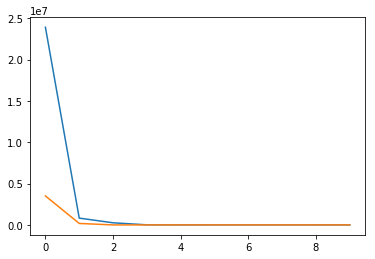

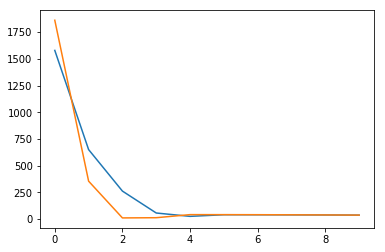

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()
plt.close()

plt.plot(history.history["mean_absolute_error"])
plt.plot(history.history["val_mean_absolute_error"])
plt.show()
plt.close()

In [ ]:
# TODO evaluate